## Criando Tabelas

In [40]:
import pandas as pd
import re
import requests
import unicodedata

In [41]:
municipal_statistics = []

In [42]:
def add_last_digit_ibge(cod6):
    cod6 = str(cod6)
    a = int(cod6[0])
    b = (int(cod6[1]) * 2) % 10 + (int(cod6[1]) * 2) // 10
    c = int(cod6[2])
    d = (int(cod6[3]) * 2) % 10 + (int(cod6[3]) * 2) // 10
    e = int(cod6[4])
    f = (int(cod6[5]) * 2) % 10 + (int(cod6[5]) * 2) // 10
    digit = (10 - (a + b + c + d + e + f) % 10) % 10
    return int(cod6) * 10 + digit


def normalize_str(s: str) -> str:
    s = s.lower().strip()
    if not isinstance(s, str):
        return s
    return ''.join(
        c for c in unicodedata.normalize('NFKD', s)
        if not unicodedata.combining(c)
    )
    return s

def normalize_string_series(s):
    return s.str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()

def get_uf_ids():
    return requests.get("https://servicodados.ibge.gov.br/api/v1/localidades/estados").json()

def get_municip_ids(uf_id):
    return requests.get(f"https://servicodados.ibge.gov.br/api/v1/localidades/estados/{uf_id}/municipios").json()

def get_municip_id(municip_name, municips) -> int:
    for municip in municips:
        if municip["nome"].strip().lower() == municip_name.lower():
            return municip["id"]
    return 0

def create_municip_dict(df):
    ufs_data = get_uf_ids()
    municips_by_uf = {}
    for uf in ufs_data:
        municips_by_uf[uf["sigla"]] = get_municip_ids(uf["id"])

    municip_dict = {}
    for row in df.itertuples():
        groups = re.search(r"(.+)\s+\((\w\w)\)", row.municipio)
        municip_name, uf_name = groups.group(1).strip(), groups.group(2).strip()
        municip_dict[normalize_str(row.municipio)] = get_municip_id(municip_name, municips_by_uf[uf_name])
    return municip_dict

### Índice de Desenvolvimento Humano Municipal - Ano 2010
Fonte: IBGE, Censo 2010

Dados disponíveis em: http://www.atlasbrasil.org.br/consulta

In [43]:
idhm_df = pd.read_csv("datasets/idhm_2010.csv")
idhm_df = idhm_df.rename(columns={"Territorialidades": "Município"})
idhm_df["IDHM 2010"] = (
    idhm_df["IDHM 2010"]
    .str.replace(",", ".", regex=False)
    .astype(float)
)
municipal_statistics.append(idhm_df)
idhm_df

,Município,IDHM 2010
0,Abadia de Goiás (GO),0.708
1,Abadia dos Dourados (MG),0.689
2,Abadiânia (GO),0.689
3,Abaeté (MG),0.698
4,Abaetetuba (PA),0.628
...,...,...
5560,Xique-Xique (BA),0.585
5561,Zabelê (PB),0.623
5562,Zacarias (SP),0.729
5563,Zé Doca (MA),0.595


### Índice FIRJAN de Desenvolvimento Municipal - Ano 2021
Fonte: Firjan

Dados disponíveis em: https://www.firjan.com.br/ifdm/downloads/

In [44]:
ifdm_df = pd.read_csv("datasets/IFDM-2021.csv")
ifdm_df["id"] = ifdm_df["id"].apply(add_last_digit_ibge)
municipal_statistics.append(ifdm_df)
ifdm_df

,id,Município,IFDM 2021
0,1100015,Alta Floresta D'Oeste,0.5411
1,1100023,Ariquemes,0.6312
2,1100031,Cabixi,0.5549
3,1100049,Cacoal,0.7067
4,1100056,Cerejeiras,0.6023
...,...,...,...
5541,5222005,Vianópolis,0.5746
5542,5222054,Vicentinópolis,0.6135
5543,5222203,Vila Boa,0.5524
5544,5222302,Vila Propício,0.5581


### Tabela 5938 - Produto interno bruto a preços correntes, impostos, líquidos de subsídios, sobre produtos a preços correntes e valor adicionado bruto a preços correntes total e por atividade econômica, e respectivas participações - Referência 2010 - Ano 2021
Fonte: IBGE, em parceria com os Órgãos Estaduais de Estatística, Secretarias Estaduais de Governo e Superintendência da Zona Franca de Manaus - SUFRAMA

Dados disponíveis em: https://sidra.ibge.gov.br/acervo

In [45]:
part_pib_df = pd.read_csv("datasets/Tabela 5938.csv")
part_pib_df["Participação PIB"] = (
    part_pib_df["Participação PIB"]
    .str.replace(",", ".", regex=False)
    .astype(float)
)
municipal_statistics.append(part_pib_df)
part_pib_df

,Município,Participação PIB
0,Alta Floresta D'Oeste (RO),10.21
1,Ariquemes (RO),56.50
2,Cabixi (RO),11.63
3,Cacoal (RO),38.83
4,Cerejeiras (RO),36.26
...,...,...
5565,Vianópolis (GO),14.84
5566,Vicentinópolis (GO),2.63
5567,Vila Boa (GO),0.62
5568,Vila Propício (GO),1.07


### Tabela 7478 - Municípios com serviço de esgotamento sanitário por rede coletora em funcionamento e com ETEs e número de ETEs, por condição de funcionamento da unidade de tratamento
Fonte: IBGE - Pesquisa Nacional de Saneamento Básico

Dados disponíveis em: https://sidra.ibge.gov.br/acervo

In [46]:
ete_df = pd.read_csv("datasets/Tabela 7478.csv")
municipal_statistics.append(ete_df)
ete_df

,Município,Municípios com serviço de esgotamento sanitário por rede coletora em funcionamento e com ETEs (Unidades),Número de ETEs (Unidades)
0,Alta Floresta D'Oeste (RO),0,0
1,Ariquemes (RO),1,2
2,Cabixi (RO),0,0
3,Cacoal (RO),1,1
4,Cerejeiras (RO),1,1
...,...,...,...
5565,Vianópolis (GO),0,0
5566,Vicentinópolis (GO),0,0
5567,Vila Boa (GO),0,0
5568,Vila Propício (GO),0,0


### Tabela 1364 - Número de municípios, total e os com serviço de abastecimento de água, por tipo de tratamento da água - Ano 2017
Fonte: IBGE - Pesquisa Nacional de Saneamento Básico

Dados disponíveis em: https://sidra.ibge.gov.br/acervo

In [47]:
agua_df = pd.read_csv("datasets/Tabela 1364.csv")
municipal_statistics.append(agua_df)
agua_df

,Município,Total de municípios abastecidos,Convencional,Não-convencional,Simples desinfecção (cloração e outros),Fluoretação
0,Alta Floresta D'Oeste (RO),1,1,0,0,0
1,Ariquemes (RO),1,1,0,0,0
2,Cabixi (RO),1,1,0,0,0
3,Cacoal (RO),1,1,0,0,0
4,Cerejeiras (RO),1,1,0,0,0
...,...,...,...,...,...,...
5565,Vianópolis (GO),1,1,0,0,1
5566,Vicentinópolis (GO),1,0,0,1,0
5567,Vila Boa (GO),1,0,1,0,0
5568,Vila Propício (GO),1,0,0,1,0


### % de cobertura vegetal natural - Ano 2017
Fonte: MapBiomas

Dados disponíveis em: http://www.atlasbrasil.org.br/consulta

In [48]:
cobertura_veg_df = pd.read_csv("datasets/cobertura_vegetal.csv")
cobertura_veg_df = cobertura_veg_df.rename(columns={"Territorialidades": "Município"})
cobertura_veg_df["% de cobertura vegetal natural 2017"] = (
    cobertura_veg_df["% de cobertura vegetal natural 2017"]
    .str.replace(",", ".", regex=False)
    .astype(float)
)
municipal_statistics.append(cobertura_veg_df)
cobertura_veg_df

,Município,% de cobertura vegetal natural 2017
0,Abadia de Goiás (GO),25.51
1,Abadia dos Dourados (MG),31.37
2,Abadiânia (GO),37.46
3,Abaeté (MG),28.02
4,Abaetetuba (PA),62.79
...,...,...
5560,Xique-Xique (BA),72.15
5561,Zabelê (PB),71.55
5562,Zacarias (SP),4.60
5563,Zé Doca (MA),35.42


### Concentração dos focos de calor - Ano 2017

Fonte: INPE

Dados disponíveis em: http://www.atlasbrasil.org.br/consulta

In [49]:
focos_calor_df = pd.read_csv("datasets/focos_calor.csv")
focos_calor_df = focos_calor_df.rename(columns={"Territorialidades": "Município"})
focos_calor_df["Concentração dos focos de calor 2017"] = (
    focos_calor_df["Concentração dos focos de calor 2017"]
    .str.replace(",", ".", regex=False)
    .astype(float)
)
municipal_statistics.append(focos_calor_df)
focos_calor_df

,Município,Concentração dos focos de calor 2017
0,Abadia de Goiás (GO),0.01
1,Abadia dos Dourados (MG),0.05
2,Abadiânia (GO),0.07
3,Abaeté (MG),0.05
4,Abaetetuba (PA),0.28
...,...,...
5560,Xique-Xique (BA),0.68
5561,Zabelê (PB),0.00
5562,Zacarias (SP),0.01
5563,Zé Doca (MA),0.64


### Óbitos por causas evitáveis de 5 a 74 anos - Brasil - Ano 2021
Fonte: MS/SVSA/CGIAE - Sistema de Informações sobre Mortalidade - SIM

Dados disponíveis em: http://siab.datasus.gov.br/DATASUS/index.php

In [50]:
mortes_evit = pd.read_csv("datasets/sim_cnv_evitb10br112143187_60_133_88.csv")
mortes_evit["ID"] = mortes_evit["ID"].apply(add_last_digit_ibge)
municipal_statistics.append(mortes_evit)
mortes_evit

,ID,Município,Óbitos_p/Residência
0,1100015,ALTA FLORESTA D'OESTE,111
1,1100023,ARIQUEMES,661
2,1100031,CABIXI,30
3,1100049,CACOAL,486
4,1100056,CEREJEIRAS,102
...,...,...,...
5565,5222005,VIANOPOLIS,82
5566,5222054,VICENTINOPOLIS,52
5567,5222203,VILA BOA,14
5568,5222302,VILA PROPICIO,32


### Homicídios - Ano 2021
Fonte: MS/SVS/CGIAE - Sistema de Informações sobre Mortalidade - SIM

Dados disponíveis em: https://www.ipea.gov.br/atlasviolencia

In [51]:
homicidios_df = pd.read_csv("datasets/homicidios-2021-01-15-2021-01-15.csv")
homicidios_df = homicidios_df[homicidios_df["Homicídios"] != 0]
homicidios_df

,id,Município,Homicídios
0,1100015,Alta Floresta D'Oeste,5
1,1100023,Ariquemes,29
2,1100031,Cabixi,1
3,1100049,Cacoal,18
4,1100056,Cerejeiras,9
...,...,...,...
5556,5222005,Vianópolis,3
5557,5222054,Vicentinópolis,2
5558,5222203,Vila Boa,3
5559,5222302,Vila Propício,2


### Estimativas de população publicadas no DOU - Ano 2021
Fonte: IBGE

Dados disponíveis em: https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html

In [52]:
populacao_df = pd.read_csv("datasets/estimativa_dou_2021.csv")
populacao_df

,UF,id,Município,População Estimada
0,RO,1100015,Alta Floresta D'Oeste,22516
1,RO,1100023,Ariquemes,111148
2,RO,1100031,Cabixi,5067
3,RO,1100049,Cacoal,86416
4,RO,1100056,Cerejeiras,16088
...,...,...,...,...
5565,GO,5222005,Vianópolis,14088
5566,GO,5222054,Vicentinópolis,9002
5567,GO,5222203,Vila Boa,6451
5568,GO,5222302,Vila Propício,5941


In [53]:
populacao_df = populacao_df.drop(columns=["Município"])
homicidios_df = pd.merge(homicidios_df, populacao_df, on="id", how="inner")
homicidios_df

,id,Município,Homicídios,UF,População Estimada
0,1100015,Alta Floresta D'Oeste,5,RO,22516
1,1100023,Ariquemes,29,RO,111148
2,1100031,Cabixi,1,RO,5067
3,1100049,Cacoal,18,RO,86416
4,1100056,Cerejeiras,9,RO,16088
...,...,...,...,...,...
3933,5222005,Vianópolis,3,GO,14088
3934,5222054,Vicentinópolis,2,GO,9002
3935,5222203,Vila Boa,3,GO,6451
3936,5222302,Vila Propício,2,GO,5941


### Taxa de Homicídios por 100 mil habitantes - Ano 2021
Fonte: Dados de homicídios e populacionais acima

In [54]:
homicidios_df["Taxa de Homicídios"] = homicidios_df["Homicídios"] / homicidios_df["População Estimada"] * 100_000
municipal_statistics.append(homicidios_df)
homicidios_df

,id,Município,Homicídios,UF,População Estimada,Taxa de Homicídios
0,1100015,Alta Floresta D'Oeste,5,RO,22516,22.206431
1,1100023,Ariquemes,29,RO,111148,26.091338
2,1100031,Cabixi,1,RO,5067,19.735544
3,1100049,Cacoal,18,RO,86416,20.829476
4,1100056,Cerejeiras,9,RO,16088,55.942317
...,...,...,...,...,...,...
3933,5222005,Vianópolis,3,GO,14088,21.294719
3934,5222054,Vicentinópolis,2,GO,9002,22.217285
3935,5222203,Vila Boa,3,GO,6451,46.504418
3936,5222302,Vila Propício,2,GO,5941,33.664366


### Taxa de óbitos em acidentes de transporte por 100 mil habitantes - Ano 2021
Fonte: MS/SVS/CGIAE - Sistema de Informações sobre Mortalidade - SIM

Dados dísponiveis em: https://www.ipea.gov.br/atlasviolencia

In [55]:
taxa_acidentes_df = pd.read_csv("datasets/taxa-de-obitos-em-acidentes-de-transporte.csv")
taxa_acidentes_df = taxa_acidentes_df[taxa_acidentes_df["Taxa de Acidentes de Trânsito"] != 0]
municipal_statistics.append(taxa_acidentes_df)
taxa_acidentes_df

,ID,Município,Taxa de Acidentes de Trânsito
0,3133907,Itaverava,56.38
1,2104081,Fernando Falcão,18.94
2,5201454,Aparecida do Rio Doce,80.84
3,3117603,Conceição do Pará,17.99
4,3500808,Alfredo Marcondes,47.61
...,...,...,...
5555,2925956,Rafael Jambeiro,17.67
5556,2208106,Pimenteiras,49.38
5557,3510302,Capela do Alto,23.52
5558,4202073,Balneário Gaivota,8.67


### Tabela 6580 - Pessoas de 14 anos ou mais de idade, por condição em relação à força de trabalho e condição de ocupação na semana de referência, sexo e grupos de idade - Ano 2022
Fonte: Fonte: IBGE - Censo Demográfico

Dados disponíveis em: https://sidra.ibge.gov.br/pesquisa/censo-demografico/demografico-2022/amostra-trabalho-e-rendimento

In [56]:
ocupacao_df = pd.read_csv("datasets/Tabela 6580.csv")

ocupacao_df["Força de trabalho - desocupada"] = (
    ocupacao_df["Força de trabalho - desocupada"]
    .str.replace(",", ".", regex=False)
    .astype(float)
)

ocupacao_df["Força de trabalho"] = (
    ocupacao_df["Força de trabalho"]
    .str.replace(",", ".", regex=False)
    .astype(float)
)

ocupacao_df["Taxa de desemprego"] = ocupacao_df["Força de trabalho - desocupada"] / ocupacao_df["Força de trabalho"] * 100
municipal_statistics.append(ocupacao_df)
ocupacao_df

,Município,Força de trabalho,Força de trabalho - desocupada,Taxa de desemprego
0,Alta Floresta D'Oeste (RO),55.04,0.93,1.689680
1,Ariquemes (RO),61.58,1.76,2.858071
2,Cabixi (RO),53.91,0.88,1.632350
3,Cacoal (RO),58.64,1.24,2.114598
4,Cerejeiras (RO),57.28,0.82,1.431564
...,...,...,...,...
5536,Vianópolis (GO),63.34,1.46,2.305021
5537,Vicentinópolis (GO),61.00,0.94,1.540984
5538,Vila Boa (GO),47.60,0.40,0.840336
5539,Vila Propício (GO),52.11,2.35,4.509691


### Tabela 10280 - Pessoas de 14 anos ou mais de idade, ocupadas na semana de referência, com rendimento de trabalho, Valor do rendimento nominal mensal médio e mediano de todos os trabalhos - Ano 2022
Fonte: Fonte: IBGE - Censo Demográfico

Dados disponíveis em: https://sidra.ibge.gov.br/pesquisa/censo-demografico/demografico-2022/amostra-trabalho-e-rendimento

In [57]:
rendimento_df = pd.read_csv("datasets/Tabela 10280.csv")
municipal_statistics.append(rendimento_df)
rendimento_df

,Município,Rendimento nominal médio mensal,Rendimento nominal mediano mensal
0,Alta Floresta D'Oeste (RO),2154.81,1500
1,Ariquemes (RO),2569.41,1800
2,Cabixi (RO),2281.93,1700
3,Cacoal (RO),2781.78,1800
4,Cerejeiras (RO),2741.65,1800
...,...,...,...
5565,Vianópolis (GO),2949.36,1800
5566,Vicentinópolis (GO),2304.42,1800
5567,Vila Boa (GO),1840.89,1300
5568,Vila Propício (GO),2161.76,1500


### Tabela 9543 - Taxa de alfabetização das pessoas de 15 anos ou mais de idade por grupos de idade - Ano 2022
Fonte: Fonte: IBGE - Censo Demográfico

Dados disponíveis em: https://sidra.ibge.gov.br/pesquisa/censo-demografico/demografico-2022/universo-alfabetizacao

In [58]:
alfabetizacao_df = pd.read_csv("datasets/Tabela 9543.csv")
municipal_statistics.append(alfabetizacao_df)
alfabetizacao_df

,Município,Alfab - Total,Alfab - 15 a 19 anos,Alfab – 20 a 24 anos,Alfab – 25 a 34 anos,Alfab – 35 a 44 anos,Alfab – 45 a 54 anos,Alfab – 55 a 64 anos,Alfab – 65 anos ou mais
0,Alta Floresta D'Oeste (RO),91.59,99.52,98.96,98.46,97.31,92.28,84.25,67.54
1,Ariquemes (RO),94.08,98.97,99.00,99.12,97.87,94.46,87.77,71.36
2,Cabixi (RO),89.82,97.60,97.99,98.09,95.90,94.62,84.87,67.28
3,Cacoal (RO),93.71,98.77,98.51,98.63,98.09,94.97,87.90,72.40
4,Cerejeiras (RO),92.15,98.60,98.19,98.58,98.03,93.43,86.27,68.70
...,...,...,...,...,...,...,...,...,...
5565,Vianópolis (GO),93.45,98.85,99.19,98.53,97.03,93.29,88.16,78.03
5566,Vicentinópolis (GO),90.87,98.53,97.80,97.92,93.90,88.79,81.90,69.30
5567,Vila Boa (GO),87.17,98.72,95.75,97.24,94.59,83.56,71.57,53.87
5568,Vila Propício (GO),85.68,97.96,97.30,97.13,95.20,85.03,74.51,57.23


### União das tabelas

In [59]:
municip_ids = {}
for df in municipal_statistics:
    df.columns = normalize_string_series(df.columns)
    if "id" not in df:
        municip_ids = create_municip_dict(df)
        break


main_df = pd.DataFrame(municip_ids.items(), columns=["municipio", "id"])
for df in municipal_statistics:
    df.columns = normalize_string_series(df.columns)
    df["municipio"] = normalize_string_series(df["municipio"])
    if "id" in df:
        df = df.drop(columns=["municipio"])
        main_df = pd.merge(main_df, df, on="id", how="inner")
    else:
        main_df = pd.merge(main_df, df, on="municipio", how="inner")

main_df = main_df.dropna()
pd.set_option("display.max_columns", None)
main_df

,municipio,id,idhm 2010,ifdm 2021,participacao pib,municipios com servico de esgotamento sanitario por rede coletora em funcionamento e com etes (unidades),numero de etes (unidades),total de municipios abastecidos,convencional,nao-convencional,simples desinfeccao (cloracao e outros),fluoretacao,% de cobertura vegetal natural 2017,concentracao dos focos de calor 2017,obitos_p/residencia,homicidios,uf,populacao estimada,taxa de homicidios,taxa de acidentes de transito,forca de trabalho,forca de trabalho - desocupada,taxa de desemprego,rendimento nominal medio mensal,rendimento nominal mediano mensal,alfab - total,alfab - 15 a 19 anos,alfab 20 a 24 anos,alfab 25 a 34 anos,alfab 35 a 44 anos,alfab 45 a 54 anos,alfab 55 a 64 anos,alfab 65 anos ou mais
0,abadia de goias (go),5200050,0.708,0.5175,0.39,1,1,1,1,0,1,1,25.51,0.01,84,10,GO,9158,109.194147,43.68,57.26,1.51,2.637094,2203.94,1500,94.27,98.68,98.34,98.01,97.03,93.45,88.60,76.62
1,abadiania (go),5200100,0.689,0.5800,1.54,1,1,1,1,0,0,1,37.46,0.07,96,1,GO,20873,4.790878,14.37,54.34,1.88,3.459698,1957.93,1400,92.76,98.90,98.76,98.71,97.10,92.93,89.10,75.47
2,abaete (mg),3100203,0.698,0.6262,9.71,0,0,1,1,0,0,1,28.02,0.05,120,1,MG,23263,4.298672,8.60,58.66,2.17,3.699284,2227.07,1500,93.71,99.21,98.79,98.84,97.14,94.83,91.61,82.72
3,abaetetuba (pa),1500107,0.628,0.3853,32.65,0,0,1,1,0,1,0,62.79,0.28,530,56,PA,160439,34.904232,9.97,49.21,3.46,7.031091,1491.30,1200,89.91,97.81,97.75,96.95,92.92,86.37,77.60,62.99
4,abaiara (ce),2300101,0.628,0.5136,8.00,0,0,1,0,0,1,0,47.44,0.02,35,1,CE,11965,8.357710,16.72,43.92,4.56,10.382514,1081.19,1000,76.84,97.62,97.48,94.89,83.29,66.75,58.06,41.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,xexeu (pe),2616506,0.552,0.4356,1.85,0,0,1,1,0,0,0,18.96,0.01,94,8,PE,14789,54.094259,27.05,36.05,3.24,8.987517,1435.79,1212,74.17,97.06,95.65,91.34,80.45,65.48,49.73,35.40
3474,xinguara (pa),1508407,0.646,0.5168,26.67,0,0,1,0,1,1,0,19.63,1.07,224,18,PA,45416,39.633609,33.03,61.37,1.93,3.144859,2186.28,1212,90.68,98.27,98.37,97.72,94.41,88.06,78.06,60.52
3475,xique-xique (ba),2933604,0.585,0.3308,24.22,0,0,1,1,0,1,1,72.15,0.68,221,9,BA,46562,19.329067,15.03,46.19,3.17,6.862957,1375.73,1200,83.19,96.81,97.21,94.99,89.46,76.90,66.75,54.23
3476,zabele (pb),2517407,0.623,0.5549,1.59,1,2,1,0,0,0,0,71.55,0.00,11,1,PB,2269,44.072279,176.29,34.81,4.05,11.634588,1276.44,1200,80.60,97.94,99.35,98.09,89.23,75.18,66.13,49.26


### Normalização de todos os dados para o intervalo [0, 1]

In [60]:
from sklearn.preprocessing import MinMaxScaler

normalized_main_df = main_df.copy(deep=True)

normalized_main_df[["participacao pib", "% de cobertura vegetal natural 2017", "forca de trabalho",
     "forca de trabalho - desocupada", "taxa de desemprego"]] = main_df[["participacao pib", "% de cobertura vegetal natural 2017", "forca de trabalho",
     "forca de trabalho - desocupada", "taxa de desemprego"]].apply(lambda x: x / 100)

alfab_cols = [c for c in df.columns if "alfab" in c]
normalized_main_df[alfab_cols] = main_df[alfab_cols].apply(lambda x: x / 100)
normalized_main_df[["taxa de homicidios",
                    "taxa de acidentes de transito"]] = main_df[["taxa de homicidios",
                                                                 "taxa de acidentes de transito"]].apply(lambda x: x / 100_000)
normalized_main_df[[
    "obitos_p/residencia",
    "concentracao dos focos de calor 2017",
    "rendimento nominal medio mensal",
    "rendimento nominal mediano mensal",
    "homicidios",
    "populacao estimada",
    "numero de etes (unidades)"
]] = MinMaxScaler().fit_transform(
    main_df[["obitos_p/residencia", "concentracao dos focos de calor 2017", "rendimento nominal medio mensal",
             "rendimento nominal mediano mensal", "homicidios", "populacao estimada", "numero de etes (unidades)"]]
)
normalized_main_df

,municipio,id,idhm 2010,ifdm 2021,participacao pib,municipios com servico de esgotamento sanitario por rede coletora em funcionamento e com etes (unidades),numero de etes (unidades),total de municipios abastecidos,convencional,nao-convencional,simples desinfeccao (cloracao e outros),fluoretacao,% de cobertura vegetal natural 2017,concentracao dos focos de calor 2017,obitos_p/residencia,homicidios,uf,populacao estimada,taxa de homicidios,taxa de acidentes de transito,forca de trabalho,forca de trabalho - desocupada,taxa de desemprego,rendimento nominal medio mensal,rendimento nominal mediano mensal,alfab - total,alfab - 15 a 19 anos,alfab 20 a 24 anos,alfab 25 a 34 anos,alfab 35 a 44 anos,alfab 45 a 54 anos,alfab 55 a 64 anos,alfab 65 anos ou mais
0,abadia de goias (go),5200050,0.708,0.5175,0.0039,1,0.012346,1,1,0,1,1,0.2551,0.000311,0.001312,0.005155,GO,0.000664,0.001092,0.000437,0.5726,0.0151,0.026371,0.234231,0.333333,0.9427,0.9868,0.9834,0.9801,0.9703,0.9345,0.8860,0.7662
1,abadiania (go),5200100,0.689,0.5800,0.0154,1,0.012346,1,1,0,0,1,0.3746,0.002175,0.001512,0.000000,GO,0.001609,0.000048,0.000144,0.5434,0.0188,0.034597,0.194365,0.300000,0.9276,0.9890,0.9876,0.9871,0.9710,0.9293,0.8910,0.7547
2,abaete (mg),3100203,0.698,0.6262,0.0971,0,0.000000,1,1,0,0,1,0.2802,0.001553,0.001911,0.000000,MG,0.001802,0.000043,0.000086,0.5866,0.0217,0.036993,0.237979,0.333333,0.9371,0.9921,0.9879,0.9884,0.9714,0.9483,0.9161,0.8272
3,abaetetuba (pa),1500107,0.628,0.3853,0.3265,0,0.000000,1,1,0,1,0,0.6279,0.008698,0.008722,0.031501,PA,0.012868,0.000349,0.000100,0.4921,0.0346,0.070311,0.118748,0.233333,0.8991,0.9781,0.9775,0.9695,0.9292,0.8637,0.7760,0.6299
4,abaiara (ce),2300101,0.628,0.5136,0.0800,0,0.000000,1,0,0,1,0,0.4744,0.000621,0.000498,0.000000,CE,0.000890,0.000084,0.000167,0.4392,0.0456,0.103825,0.052290,0.166667,0.7684,0.9762,0.9748,0.9489,0.8329,0.6675,0.5806,0.4167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,xexeu (pe),2616506,0.552,0.4356,0.0185,0,0.000000,1,1,0,0,0,0.1896,0.000311,0.001479,0.004009,PE,0.001118,0.000541,0.000271,0.3605,0.0324,0.089875,0.109753,0.237333,0.7417,0.9706,0.9565,0.9134,0.8045,0.6548,0.4973,0.3540
3474,xinguara (pa),1508407,0.646,0.5168,0.2667,0,0.000000,1,0,1,1,0,0.1963,0.033240,0.003638,0.009737,PA,0.003589,0.000396,0.000330,0.6137,0.0193,0.031449,0.231369,0.237333,0.9068,0.9827,0.9837,0.9772,0.9441,0.8806,0.7806,0.6052
3475,xique-xique (ba),2933604,0.585,0.3308,0.2422,0,0.000000,1,1,0,1,1,0.7215,0.021125,0.003589,0.004582,BA,0.003681,0.000193,0.000150,0.4619,0.0317,0.068630,0.100020,0.233333,0.8319,0.9681,0.9721,0.9499,0.8946,0.7690,0.6675,0.5423
3476,zabele (pb),2517407,0.623,0.5549,0.0159,1,0.024691,1,0,0,0,0,0.7155,0.000000,0.000100,0.000000,PB,0.000108,0.000441,0.001763,0.3481,0.0405,0.116346,0.083930,0.233333,0.8060,0.9794,0.9935,0.9809,0.8923,0.7518,0.6613,0.4926


In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

features = [
    'participacao pib', '% de cobertura vegetal natural 2017',
    'concentracao dos focos de calor 2017', 'obitos_p/residencia',
    'homicidios', 'populacao estimada', 'taxa de homicidios',
    'taxa de acidentes de transito', 'forca de trabalho',
    'forca de trabalho - desocupada', 'taxa de desemprego',
    'rendimento nominal medio mensal', 'rendimento nominal mediano mensal',
    'alfab - total'
]

X = normalized_main_df[features]
y = normalized_main_df['idhm 2010']

rf = RandomForestRegressor(n_estimators=500, random_state=42)

rf.fit(X, y)

importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False).reset_index()
importance.columns = ['metrica', 'importancia']
importance

,metrica,importancia
0,alfab - total,0.439600
1,rendimento nominal medio mensal,0.424126
2,forca de trabalho,0.023413
3,concentracao dos focos de calor 2017,0.022221
4,% de cobertura vegetal natural 2017,0.021205
5,taxa de acidentes de transito,0.011021
6,participacao pib,0.009624
7,rendimento nominal mediano mensal,0.009403
8,obitos_p/residencia,0.008657
9,taxa de homicidios,0.008568


In [62]:
print(main_df.columns)

Index(['municipio', 'id', 'idhm 2010', 'ifdm 2021', 'participacao pib',
       'municipios com servico de esgotamento sanitario por rede coletora em funcionamento e com etes (unidades)',
       'numero de etes (unidades)', 'total de municipios abastecidos',
       'convencional', 'nao-convencional',
       'simples desinfeccao (cloracao e outros)', 'fluoretacao',
       '% de cobertura vegetal natural 2017',
       'concentracao dos focos de calor 2017', 'obitos_p/residencia',
       'homicidios', 'uf', 'populacao estimada', 'taxa de homicidios',
       'taxa de acidentes de transito', 'forca de trabalho',
       'forca de trabalho - desocupada', 'taxa de desemprego',
       'rendimento nominal medio mensal', 'rendimento nominal mediano mensal',
       'alfab - total', 'alfab - 15 a 19 anos', 'alfab  20 a 24 anos',
       'alfab  25 a 34 anos', 'alfab  35 a 44 anos', 'alfab  45 a 54 anos',
       'alfab  55 a 64 anos', 'alfab  65 anos ou mais'],
      dtype='object')


In [63]:
features = [
    'participacao pib',
    'municipios com servico de esgotamento sanitario por rede coletora em funcionamento e com etes (unidades)',
    'numero de etes (unidades)', 'total de municipios abastecidos',
    'convencional', 'nao-convencional',
    'simples desinfeccao (cloracao e outros)', 'fluoretacao',
    '% de cobertura vegetal natural 2017',
    'concentracao dos focos de calor 2017', 'obitos_p/residencia',
    'homicidios', 'populacao estimada', 'taxa de homicidios',
    'taxa de acidentes de transito', 'forca de trabalho',
    'forca de trabalho - desocupada', 'taxa de desemprego',
    'rendimento nominal medio mensal', 'rendimento nominal mediano mensal',
    'alfab - total', 'alfab - 15 a 19 anos', 'alfab  20 a 24 anos',
    'alfab  25 a 34 anos', 'alfab  35 a 44 anos', 'alfab  45 a 54 anos',
    'alfab  55 a 64 anos', 'alfab  65 anos ou mais'
]

X = normalized_main_df[features]

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)
main_df['cluster'] = clusters
main_df

,municipio,id,idhm 2010,ifdm 2021,participacao pib,municipios com servico de esgotamento sanitario por rede coletora em funcionamento e com etes (unidades),numero de etes (unidades),total de municipios abastecidos,convencional,nao-convencional,simples desinfeccao (cloracao e outros),fluoretacao,% de cobertura vegetal natural 2017,concentracao dos focos de calor 2017,obitos_p/residencia,homicidios,uf,populacao estimada,taxa de homicidios,taxa de acidentes de transito,forca de trabalho,forca de trabalho - desocupada,taxa de desemprego,rendimento nominal medio mensal,rendimento nominal mediano mensal,alfab - total,alfab - 15 a 19 anos,alfab 20 a 24 anos,alfab 25 a 34 anos,alfab 35 a 44 anos,alfab 45 a 54 anos,alfab 55 a 64 anos,alfab 65 anos ou mais,cluster
0,abadia de goias (go),5200050,0.708,0.5175,0.39,1,1,1,1,0,1,1,25.51,0.01,84,10,GO,9158,109.194147,43.68,57.26,1.51,2.637094,2203.94,1500,94.27,98.68,98.34,98.01,97.03,93.45,88.60,76.62,0
1,abadiania (go),5200100,0.689,0.5800,1.54,1,1,1,1,0,0,1,37.46,0.07,96,1,GO,20873,4.790878,14.37,54.34,1.88,3.459698,1957.93,1400,92.76,98.90,98.76,98.71,97.10,92.93,89.10,75.47,1
2,abaete (mg),3100203,0.698,0.6262,9.71,0,0,1,1,0,0,1,28.02,0.05,120,1,MG,23263,4.298672,8.60,58.66,2.17,3.699284,2227.07,1500,93.71,99.21,98.79,98.84,97.14,94.83,91.61,82.72,1
3,abaetetuba (pa),1500107,0.628,0.3853,32.65,0,0,1,1,0,1,0,62.79,0.28,530,56,PA,160439,34.904232,9.97,49.21,3.46,7.031091,1491.30,1200,89.91,97.81,97.75,96.95,92.92,86.37,77.60,62.99,4
4,abaiara (ce),2300101,0.628,0.5136,8.00,0,0,1,0,0,1,0,47.44,0.02,35,1,CE,11965,8.357710,16.72,43.92,4.56,10.382514,1081.19,1000,76.84,97.62,97.48,94.89,83.29,66.75,58.06,41.67,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,xexeu (pe),2616506,0.552,0.4356,1.85,0,0,1,1,0,0,0,18.96,0.01,94,8,PE,14789,54.094259,27.05,36.05,3.24,8.987517,1435.79,1212,74.17,97.06,95.65,91.34,80.45,65.48,49.73,35.40,3
3474,xinguara (pa),1508407,0.646,0.5168,26.67,0,0,1,0,1,1,0,19.63,1.07,224,18,PA,45416,39.633609,33.03,61.37,1.93,3.144859,2186.28,1212,90.68,98.27,98.37,97.72,94.41,88.06,78.06,60.52,2
3475,xique-xique (ba),2933604,0.585,0.3308,24.22,0,0,1,1,0,1,1,72.15,0.68,221,9,BA,46562,19.329067,15.03,46.19,3.17,6.862957,1375.73,1200,83.19,96.81,97.21,94.99,89.46,76.90,66.75,54.23,0
3476,zabele (pb),2517407,0.623,0.5549,1.59,1,2,1,0,0,0,0,71.55,0.00,11,1,PB,2269,44.072279,176.29,34.81,4.05,11.634588,1276.44,1200,80.60,97.94,99.35,98.09,89.23,75.18,66.13,49.26,3


## Análise

### Divisão dos municípios em classes
- Os municípios foram divididos em 5 classes.
- Cada município recebeu 3 números: classe do IDHM, classe do IFDM e cluster.

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def plot_map(df_map, mapping_column, title, colors, labels, no_data_color='#cccccc'):
    colors = colors + [no_data_color]
    color_mapping = {0: colors[0], 1: colors[1], 2: colors[2], 3: colors[3], 4: colors[4], -1: no_data_color}
    df_map['plot_color'] = df_map[mapping_column].map(color_mapping)

    fig, ax = plt.subplots(figsize=(12, 12))

    gdf.plot(color=df_map['plot_color'], edgecolor=None, linewidth=0, ax=ax)

    ax.set_title(title, fontsize=16)

    ax.axis('off')

    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
    ax.legend(handles=patches, loc='lower left', fontsize=12)

    plt.show()


In [65]:
gdf = gpd.read_file('BR_Municipios_2024/BR_Municipios_2024.shp')

gdf['id'] = gdf['CD_MUN'].astype('int64')
df_map = gdf.merge(main_df, on='id', how='left')

bins = [0, 0.500, 0.600, 0.700, 0.800, 1.0]  # IDHM ranges

df_map['idhm_bin'] = pd.cut(df_map['idhm 2010'], bins=bins, labels=False)
df_map['idhm_bin'] = df_map['idhm_bin'].fillna(-1)
df_map['ifdm_bin'] = pd.cut(df_map['ifdm 2021'], bins=bins, labels=False)
df_map['ifdm_bin'] = df_map['ifdm_bin'].fillna(-1)

idhm_labels = ['Muito Baixo (<0.500)', 'Baixo (0.500-0.599)', 'Médio (0.599–0.699)', 'Alto (0.700–0.799)', 'Muito Alto (≥0.800)', 'Sem Dados']
idhm_colors = ['#c63332', '#d2d127', '#91d21e', '#18984e', '#094c76']

df_map['cluster'] = df_map['cluster'].fillna(-1)

cluster_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
cluster_colors = ['#c994e8', '#a75dd3', '#822dbb', '#5e0fa3', '#3b0078']

### Mapas

Os mapas foram criados com base na divisão acima. Os últimos dados do IDHM disponíveis são do Censo 2010. Por isso, o indíce IFDM também foi usado como forma de comparação já que possui dados mais recentes.

Os 3 mapas mostraram uma grande correlação entre a clusterização feita com Kmeans usando as variáveis numéricas e os dois índices. Portanto, os dados escolhidos foram bons para representar o desenvolvimento de cada município.

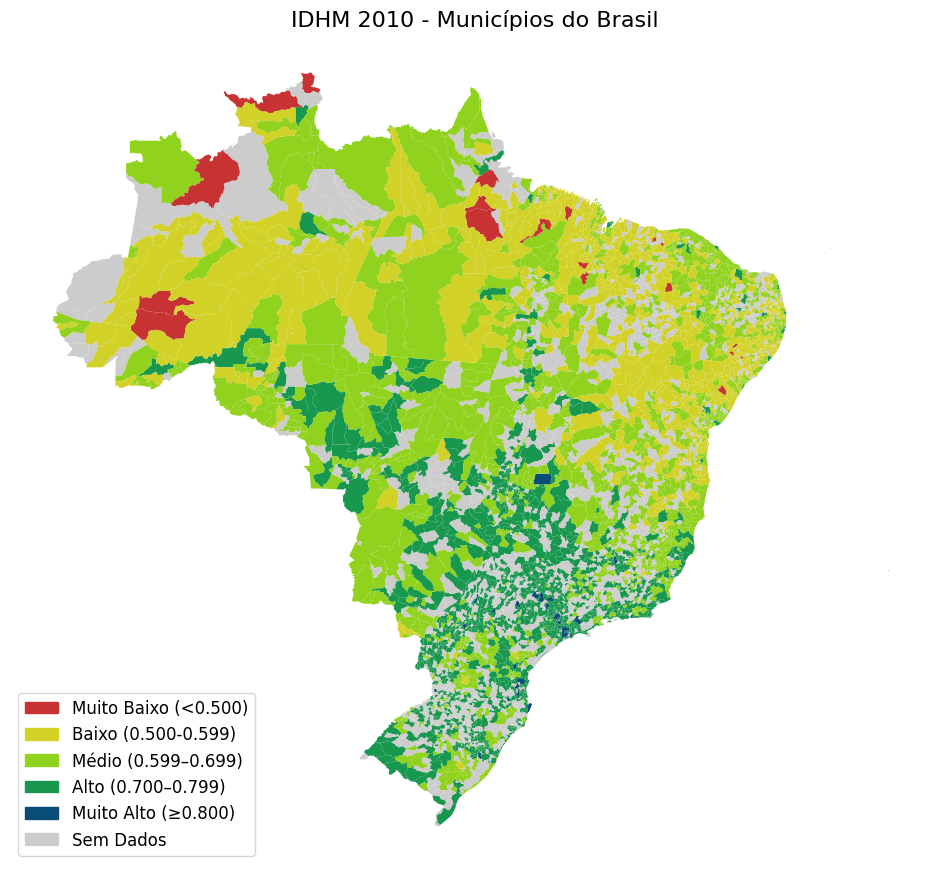

In [66]:
plot_map(df_map, 'idhm_bin', 'IDHM 2010 - Municípios do Brasil', idhm_colors, idhm_labels)

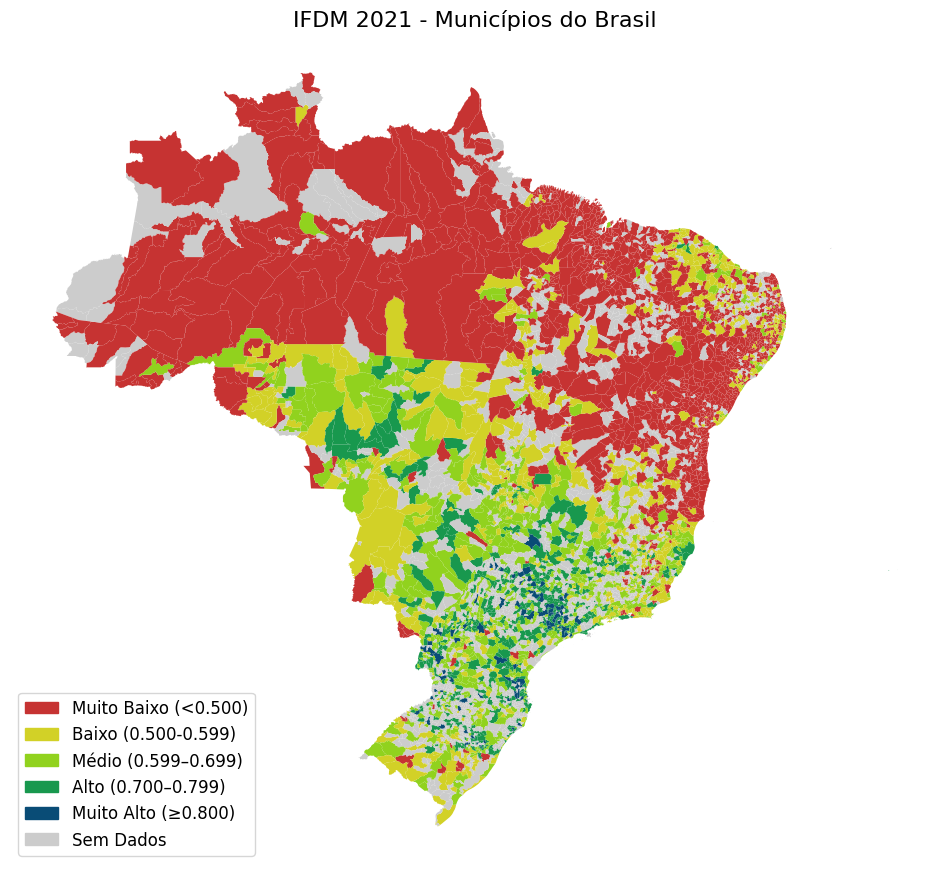

In [67]:
plot_map(df_map, 'ifdm_bin', 'IFDM 2021 - Municípios do Brasil', idhm_colors, idhm_labels)

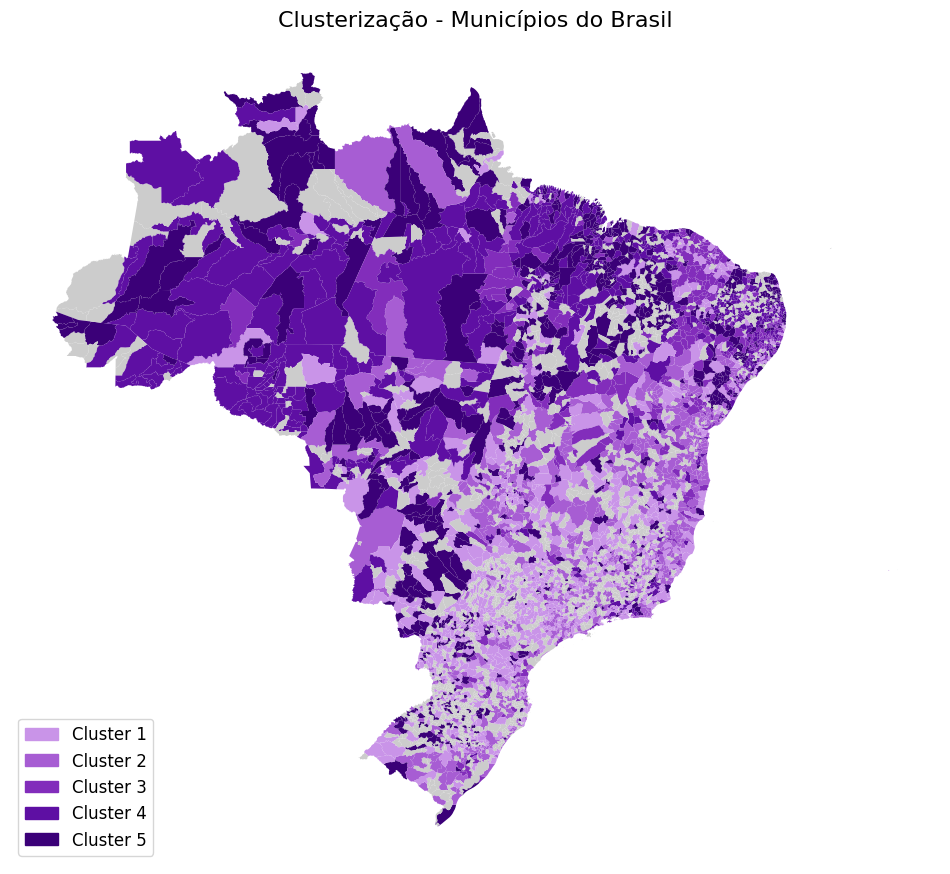

In [68]:
plot_map(df_map, 'cluster', 'Clusterização - Municípios do Brasil', cluster_colors, cluster_labels)

### Importância dos atributos para o IDHM (Regressão)

As duas primeiras posições de importância foram como o esperado. O PIB per capita e a alfabetização fazem parte do cálculo do IDHM, então métricas relacionadas ficaram nas primeiras posições.

Em terceiro lugar, vem "forca de trabalho", que representa a porcentagem da população economicamente ativa.

Em seguida, para concluir o top 5, estão métricas relacionadas ao meio ambiente.

In [69]:
importance

,metrica,importancia
0,alfab - total,0.439600
1,rendimento nominal medio mensal,0.424126
2,forca de trabalho,0.023413
3,concentracao dos focos de calor 2017,0.022221
4,% de cobertura vegetal natural 2017,0.021205
5,taxa de acidentes de transito,0.011021
6,participacao pib,0.009624
7,rendimento nominal mediano mensal,0.009403
8,obitos_p/residencia,0.008657
9,taxa de homicidios,0.008568


### Abaixo estão as médias e desvios padrões de cada cluster formado

In [70]:
numeric_cols = main_df.select_dtypes(include=['number']).columns
numeric_cols = [c for c in numeric_cols if c not in ['id', 'cluster']]
cluster_summary = main_df.groupby('cluster')[numeric_cols].agg(['mean', 'std'])
cluster_summary

idhm 2010           ifdm 2021           participacao pib             \
             mean       std      mean       std             mean        std   
cluster                                                                       
0        0.707389  0.059869  0.646534  0.115261        19.201120  21.497984   
1        0.680491  0.067325  0.577690  0.131185        12.866692  16.077810   
2        0.617181  0.055227  0.497560  0.099765        12.310603  15.065495   
3        0.600798  0.056563  0.447963  0.111624        12.366509  14.953568   
4        0.628488  0.065582  0.492822  0.128176         9.944242  12.719067   

        municipios com servico de esgotamento sanitario por rede coletora em funcionamento e com etes (unidades)  \
                                                                                                            mean   
cluster                                                                                                            
0                                                 0.781596                                                         
1                                                 0.490637                                                         
2                                                 0.326633                                                         
3                                                 0.156604                                                         
4                                                 0.127389                                                         

                  numero de etes (unidades)            \
              std                      mean       std   
cluster                                                 
0        0.413392                  2.192905  5.365905   
1        0.500225                  1.372035  4.438346   
2        0.469572                  0.638191  1.388963   
3        0.363770                  0.247170  0.778517   
4        0.333620                  0.239490  1.099035   

        total de municipios abastecidos           convencional            \
                                   mean       std         mean       std   
cluster                                                                    
0                              1.000000  0.000000     0.737251  0.440372   
1                              1.000000  0.000000     0.987516  0.111103   
2                              1.000000  0.000000     0.128141  0.334667   
3                              0.977358  0.148898     0.637736  0.481109   
4                              1.000000  0.000000     0.098089  0.297625   

        nao-convencional           simples desinfeccao (cloracao e outros)  \
                    mean       std                                    mean   
cluster                                                                      
0               0.062084  0.241442                                 1.00000   
1               0.048689  0.215352                                 0.00000   
2               1.000000  0.000000                                 0.39196   
3               0.026415  0.160518                                 0.00000   
4               0.000000  0.000000                                 1.00000   

                  fluoretacao           % de cobertura vegetal natural 2017  \
              std        mean       std                                mean   
cluster                                                                       
0        0.000000    0.935698  0.245425                           29.902517   
1        0.000000    1.000000  0.000000                           33.631723   
2        0.488802    0.459799  0.499009                           45.082965   
3        0.000000    0.015094  0.122043                           54.114509   
4        0.000000    0.277707  0.448154                           45.417325   

                   concentracao dos focos de calor 2017            \
               std                                 me